<a href="https://colab.research.google.com/github/bukhtiar-haider/short-term-stock-prediction/blob/main/Short_Term_Stock_Prediction_(AAPL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> *This notebook was created as part of the CS969 Big Data for Computational Finance Coursework*<br>
> *Author: Muhammad Bukhtiar Haider*<br>
> *University of Essex MS(AI)*<br>
> *bukhtiarhaider@outlook.com*



# **Machine Learning based Stock Prediction** <br>

Dataset from [*Yahoo Finance*](https://finance.yahoo.com/quote/AAPL/history) <br>
Stock name: *APPLE (AAPL)* <br>
Dataset time period: *Dec 12, 1980 - Jul 28, 2022* <br>

Copy of exact dataset may be downloaded from [*here*](https://drive.google.com/file/d/1gLPwpqDNAg17IwJL2Wi8Gul6OybSw7r5/view?usp=sharing).



*This is a stacked time-series encoder-decoder LSTM implementation for stock prediction based on market features such as Market: High, Low, Open, Close, & Volume. <br><br>This purpose of this prediction model is* **NOT** *to make long-term future predictions for stock behavior, but to approximate* **Short-Term** *stock behavior for moderate frequency trading.*

*Long-Term stock prediction is very volatile and dependant upon numerous major factors that aren't internal market features; these often require NLP over informative articles in conjunction with fake news detection to forecast statements/events that strongly affect markets.*

*This prediction model uses 1 past year worth of data to make stock-predictions that allow advantage gain via short-term trading.*

*The focus of this software, like many stock prediction systems, is* **NOT** *to predict the actual prices for stocks;* **we are interested in predicting sequences of dips and hikes as vector direction rather than vector magnitude**

**IMPORTS**

In [ ]:
#Util
import datetime
import warnings
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#ML & Numerical
import pandas as pd
import numpy as np

#Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.regularizers import l2

#Visualization
import matplotlib.pyplot as plt


# Load Data

The data we're using comes from Yahoo Finance and records stock features over stock 'High, Low, Open, Close, Volume, Adjusted Close' Values. <br>The total volume of data varies from stock to stock depending on when the stock went public; This experiment attempts to predict 'Apple' that has data available since the 1980s.<br>However, we're not interested in using 40+ years of data to make short-term predictions for the current market which is significantly different from how it has behaved for the majority of this 40 year old period.

In [ ]:
#Download data from drive
!gdown --id 1gLPwpqDNAg17IwJL2Wi8Gul6OybSw7r5

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1gLPwpqDNAg17IwJL2Wi8Gul6OybSw7r5
To: /content/AAPL.csv
100% 709k/709k [00:00<00:00, 96.1MB/s]


In [ ]:
#Load data into dataframe
df = pd.read_csv('AAPL.csv')

#Extract columns
df = df[['Date','Open', 'Close', 'Volume', 'High', 'Low']]
df

,Date,Open,Close,Volume,High,Low
0,1980-12-12,0.128348,0.128348,469033600,0.128906,0.128348
1,1980-12-15,0.122210,0.121652,175884800,0.122210,0.121652
2,1980-12-16,0.113281,0.112723,105728000,0.113281,0.112723
3,1980-12-17,0.115513,0.115513,86441600,0.116071,0.115513
4,1980-12-18,0.118862,0.118862,73449600,0.119420,0.118862
...,...,...,...,...,...,...
10489,2022-07-21,154.500000,155.350006,65086600,155.570007,151.940002
10490,2022-07-22,155.389999,154.089996,66625400,156.279999,153.410004
10491,2022-07-25,154.009995,152.949997,53623900,155.039993,152.279999
10492,2022-07-26,152.259995,151.600006,55138700,153.089996,150.800003


**TYPECAST AND SET INDEX**

In [ ]:
#Typecast date from object type to datetime type
df['Date'] = df['Date'].apply(pd.to_datetime)

#Replace numerical index column with date
df.index = df.pop('Date')

**VISUALIZE COLUMN(S)**

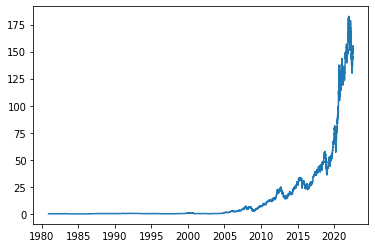

In [ ]:
plt.plot(df.index, df['Open'])

# CREATE WINDOWED DATAFRAME

The dataframe currently has a **one day value** for each feature i.e., Open Date, Close Date, Trading Volume. <br> To incorporate time series data that can be interpreted by the LSTM and/or convolutional layers, we will **combine feature values from multiple days** into a single date entry. <br> In order to acheive this we will first 'window' the dataframe into a subset that allows previous days history to be incorporated. <br> i.e. **For a 5 day history**, we must 'window' the data frame **atleast 5 cells** ahead of its first recorded value.

**DECLARE TEMPORAL REPRESENTATION FUNCTION**

In [ ]:
#The following function has been inspired by 'Microsoft Stock Forecasting with LSTMs'
#notebook by Gregg Hogg @ https://www.youtube.com/watch?v=CbTU92pbDKw

def df_to_temporal(original_df, start_dt, last_dt, n=7):
  target_date = start_dt
  
  dates = []
  X_open, X_close, X_volume, X_high, X_low, Y = [], [], [], [], [], []

  last_time = False
  while True:

    #Retrieve dataframe up to target date
    df_subset = original_df.loc[:target_date]
    #Return last 'n' rows + target date
    df_subset = df_subset.tail(n+1)
    
    if len(df_subset) != n+1:
      #In case window size exceeds possible temporal representation
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values_open = df_subset['Open'].to_numpy()
    values_close = df_subset['Close'].to_numpy()
    values_volume = df_subset['Volume'].to_numpy()
    values_high = df_subset['High'].to_numpy()
    values_low = df_subset['Low'].to_numpy()
    #Set all columns except the last to 'x'
    #Set the last column to 'y'
    x_open, x_close, x_volume, x_high, x_low, y = values_open[:-1], values_close[:-1], values_volume[:-1], values_high[:-1], values_low[:-1], values_close[-1]

    #Append to dates, X, & Y arrays
    dates.append(target_date)
    X_open.append(x_open)
    X_close.append(x_close)
    X_volume.append(x_volume)
    X_high.append(x_high)
    X_low.append(x_low)
    Y.append(y)

    #Select the next date

    #Retrieve records for the next 7 days
    next_week = original_df.loc[target_date:target_date+datetime.timedelta(days=7)]

    #Retrieve next datetime row
    next_row = next_week.head(2).tail(1)
    #Extract next datetime from row
    next_datetime = next_row.index.values[0]
    #Convert to pandas.datetime object
    dt = pd.to_datetime(next_datetime)
    #Extract day, month, year
    day, month, year = dt.day, dt.month, dt.year 

    #Change target_date object
    target_date = datetime.datetime(day=day, month=month, year=year)
    
    if last_time:
      break

    #If all rows have been converted to temporal
    #representation set flag to break loop
    if target_date == last_dt:
      last_time = True

  #Set up dataframe to be returned  
  ret_df = pd.DataFrame({})
  #Append dates
  ret_df['Target Date'] = dates
  
  #Append X values to dataframe
  X = np.array(X_open)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Open-{n-i}'] = X[:, i]
  
  #Append X values to dataframe
  X = np.array(X_close)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Close-{n-i}'] = X[:, i]
    
  #Append X values to dataframe
  X = np.array(X_volume)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Volume-{n-i}'] = X[:, i]
        
  #Append X values to dataframe
  X = np.array(X_high)
  for i in range(0, n):
    X[:, i]
    ret_df[f'High-{n-i}'] = X[:, i]
        
  #Append X values to dataframe
  X = np.array(X_low)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Low-{n-i}'] = X[:, i]
        
  #Append Y values to dataframe
  ret_df['Target'] = Y

  return ret_df

**CREATE TEMPORAL REPRESENTATION**

Fetch temporally represented market data for 1 year.

Training a model on extremely long-term data requires a significantly complex system; for example with internal and global attention, temporal convolutions, and numerous similar performing stocks such as Microsoft, Tesla, etc.

Training on older data i.e., from 1980, without a complex seq2seq, convolutional, encoder-decoder with memory will most likely result in overfitting earlier data with lower stock prices and bias the model to produce significantly lower values. **It can be argued that some rapid growth that isn't captured by the model is a result of an external feature that isn't modelled in this system**

We're only interested in short-term trend prediction to get information on when a stock is predicted to go up or down; in the next few days, for example.

In [ ]:
# Create datetime objects to make a temporal dataframe
# '2020-1-3'
# '2018-7-30'
# '2006-1-03'
# '1980-12-19'
start_date = pd.to_datetime('2021-03-23')
end_date = pd.to_datetime('2022-03-23')

df_temporal = df_to_temporal(df, start_date, end_date, n=5)

# Train/Val/Test Splits

Before the train/val/test splits can be created, we will split our dataframe into index('date'), features('X'), and target('y') columns.

**Declare extraction function**

In [ ]:
def extract_cols(dataframe):
  df_to_nparr = dataframe.to_numpy()

  #Extract dates from index column
  dates = df_to_nparr[:,0]

  #Extract target from last columnn
  y = df_to_nparr[:,-1]

  #Extract features from all other columns
  X = df_to_nparr[:, 1:-1]
  #Reshape X
  X = X.reshape((len(dates), 5, 5))

  return dates, X.astype(np.float32), y.astype(np.float32)

**Extract date, feature, and target values**

In [ ]:
dates, X, y = extract_cols(df_temporal)
dates2 = dates[1:]
X2 = X[1:]
y2 = y[:-1]
dates2.shape, X2.shape, y2.shape

((253,), (253, 5, 5), (253,))

**Split data into Train, Validation, and Test splits**<br>
Each of Validation and Test splits are 10% of the full dataframe

In [ ]:
#Splitting Testing data
dates_tmp, dates_test, X_tmp, X_test, y_tmp, y_test = train_test_split(dates, X, y, test_size = 1/10, shuffle=False)
#Splitting Validation and Training data
dates_train, dates_val, X_train, X_val, y_train, y_val = train_test_split(dates_tmp, X_tmp, y_tmp, test_size = 1/9, shuffle=False)

**SMOOTHING TARGET**
Sharp curves can throw the model off, we will smoothen the target values to train a better model.

Function adapted from [Lucas Rea](https://towardsdatascience.com/predicting-future-stock-market-trends-with-python-machine-learning-2bf3f1633b3c)

**HERE ARE THE CLOSE VALUES BEFORE SMOOTHING:**

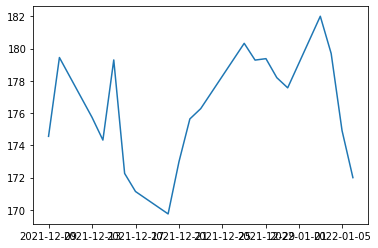

In [ ]:
plt.plot(dates_train[-20:], y_train[-20:])

In [ ]:
def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

def smoothen(data, num=1):
  data = pd.DataFrame(data)
  for i in range(num):
    data = _exponential_smooth(data, 0.65)
  return data.to_numpy()

**CLOSE VALUES AFTER TARGET SMOOTHING:**

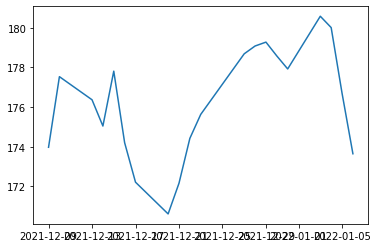

In [ ]:
y_train = smoothen(y_train)
plt.plot(dates_train[-20:], y_train[-20:])

**VISUALIZING SPLITS**

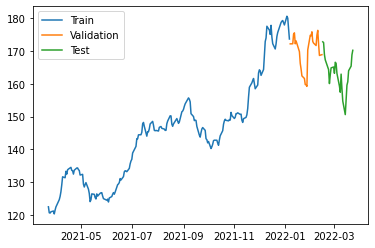

In [ ]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

# SETTING UP MODEL

**CUSTOM LOSS FUNCTION**

Use a custom loss function for our model; stock prediction is meant to be used in conjunction with trading in order to gain an advantage.

This prediction model aims to **minimize risk** by biasing the model to **penalize the difference in predictions that are larger than actual values** more heavily than the difference in predictions that are smaller than actual values.

In [ ]:
#The following function is adapted from *Daniel Möller* @https://stackoverflow.com/users/2097240/daniel-m%c3%b6ller

import keras.backend as K

def mse_penalize_greater(target,predicted):
    diff = predicted - target

    greater = K.greater(diff,0)
    greater = K.cast(greater, K.floatx()) #0 for lower, 1 for greater
    greater = greater + 1                 #1 for lower, 2 for greater

    #return loss using some loss function over 'greater'
    #we use mse
    return K.mean(greater*K.square(diff))

**STACKED TIME DISTRIBUTED ENCODER-DECODER LSTMs**

In [ ]:
model = Sequential([layers.Input((5, 5)),
                    #layers.TimeDistributed(layers.Dense(64)),
                    layers.LSTM(units=128, kernel_regularizer='l2'),
                    layers.Dropout(rate=.2),
                    layers.RepeatVector(1),
                    layers.LSTM(units=128, return_sequences=True),
                    layers.Dropout(rate=.2),
                    layers.TimeDistributed(layers.Dense(64)),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(rate=.2),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_squared_error'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 128)               68608     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_7 (RepeatVect  (None, 1, 128)           0         
 or)                                                             
                                                                 
 lstm_15 (LSTM)              (None, 1, 128)            131584    
                                                                 
 dropout_22 (Dropout)        (None, 1, 128)            0         
                                                                 
 time_distributed_7 (TimeDis  (None, 1, 64)            8256      
 tributed)                                            

In [ ]:

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size = 32)

Epoch 1/1000
7/7 [==============================] - 6s 173ms/step - loss: 21041.4238 - mean_squared_error: 21041.3320 - val_loss: 28410.8164 - val_mean_squared_error: 28410.7305
Epoch 2/1000
7/7 [==============================] - 0s 16ms/step - loss: 20501.7656 - mean_squared_error: 20501.6816 - val_loss: 27347.6074 - val_mean_squared_error: 27347.5332
Epoch 3/1000
7/7 [==============================] - 0s 16ms/step - loss: 19232.1582 - mean_squared_error: 19232.0879 - val_loss: 25001.4297 - val_mean_squared_error: 25001.3652
Epoch 4/1000
7/7 [==============================] - 0s 16ms/step - loss: 16789.6855 - mean_squared_error: 16789.6250 - val_loss: 20972.1777 - val_mean_squared_error: 20972.1211
Epoch 5/1000
7/7 [==============================] - 0s 17ms/step - loss: 13011.1064 - mean_squared_error: 13011.0508 - val_loss: 15387.0273 - val_mean_squared_error: 15386.9756
Epoch 6/1000
7/7 [==============================] - 0s 15ms/step - loss: 8298.9199 - mean_squared_error: 8298.8701

**TRAINING-VALIDATION-TESTING Prediction Trends:**

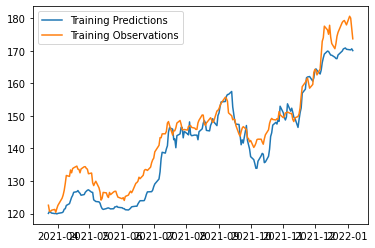

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

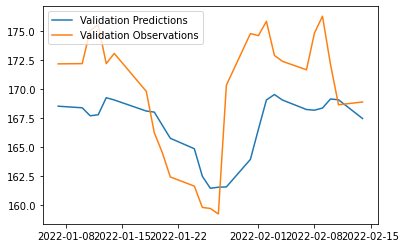

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

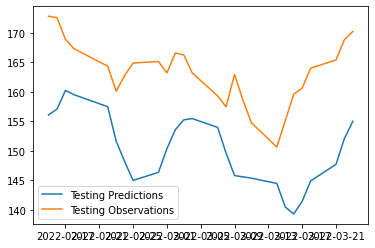

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

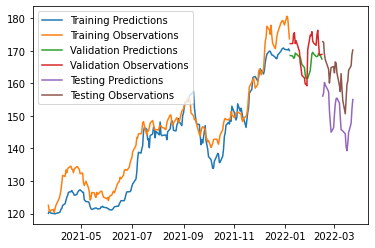

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

**CONCLUSION**

The Validation & Testing predictions **(10% of total data each)** can be clearly seen to have interpreted the underlying latent features that determine stock behavior. <br> In this regard, the system is a success - even though the magnitude of stock prices may be a little different from the actual values, the system was designed to correctly predict the behavior of when a stock value goes up or down. *As seen in the plots, it is able to do that very well*.

**FURTHER WORK**<br>
Although the stock closing value behavior has been modelled very well by the system, for future predictions the system may be adapted to perform regression over all 5 input features for the next date. <br>
That is to say that the system would output all 5 features including *Open, Close, High, Low, and Volume* values in order to have sufficient predicted information to continue predictions past a few days.<br>Additionally, rather than using a single stock to predict 'Apple' stocks, the system can employ additional input features from popular stocks such as Microsoft, Tesla, Google - Even though these are not directly determinant of Apple stocks, they hold vital information about how the market is generally behaving for that day/past few days.